# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# TODO: Fill this in based on where you saved the training and testing data
print (tf.__version__)
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


0.12.1


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = (32, 32, 3)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

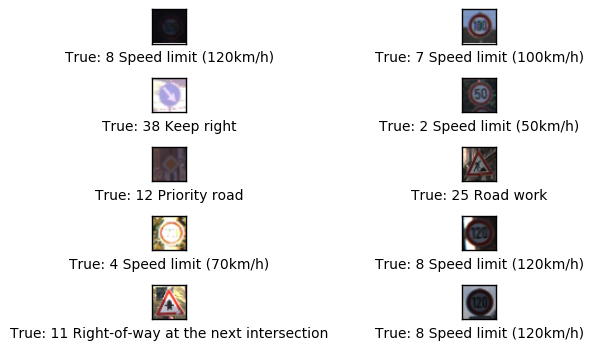

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#Load CSV file to read key and corresponding labels

with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    signnames = {rows[0]:rows[1] for rows in reader}

#Helper function to plot few images and labels

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 10
    # Create figure with 5x2 sub-plots.
    fig, axes = plt.subplots(5, 2)
    fig.subplots_adjust(hspace=1.0, wspace=1.0)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0} {1}".format(cls_true[i],signnames[str(cls_true[i])])
        else:
            xlabel = "True: {0} {1}, Pred: {2}".format(cls_true[i],signnames[str(cls_true[i])], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#Get random numbers for 10 images from the training dataset
imageList= random.sample(range(len(X_train)-1), 10)

#Get first 10 images from the train set
images_train = X_train[imageList]
#Get tru class labels
images_labels = y_train[imageList]

# Plot the images and labels using our helper-function above.
plot_images(images=images_train, cls_true=images_labels)



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Shuffle the training data.
X_train, y_train = shuffle(X_train, y_train)



In [5]:

# Function to histogram equalize image in YUV space. 
# An rgb image is taken as input and converted to YUV space. 
# An adaptive histogram equalization is performed in Y channel.
# Image is converted back to rgb space and returned.

def histogramEqualize(image):
    img_YUV = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    img_YUV[:,:,0] = clahe.apply(img_YUV[:,:,0])
    return cv2.cvtColor(img_YUV, cv2.COLOR_YUV2BGR)
    
# Normalize the features
for i in range(len(X_train)):
    X_train[i,:,:,:] = histogramEqualize(X_train[i,:,:,:])
for i in range(len(X_test)):
    X_test[i,:,:,:] = histogramEqualize(X_test[i,:,:,:])
  
# Normalize the data
X_train = X_train/255.0
X_test = X_test/255.0

#Split data into validation and test data.
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=0.1,random_state=0)




print("Training Set:   {} features".format(len(X_train)))
print("Training Set: ",y_train.shape[0],"labels")
print("Validation Set:   {} features".format(len(X_validation)))
print("Validation Set: ",y_validation.shape[0],"labels")
print("Test Set:       {} samples".format(len(X_test)))
print("Test Set: ",y_test.shape[0],"labels")

Training Set:   35288 features
Training Set:  35288 labels
Validation Set:   3921 features
Validation Set:  3921 labels
Test Set:       12630 samples
Test Set:  12630 labels


In [6]:


EPOCHS = 10
BATCH_SIZE = 1024

# Store layers weight & bias
def VggNet_Inspired(x,keep_prob1,keep_prob2):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input(x) = 32x32x3. Output = 32x32x64.
    # Weights. First 3,3 are filter height and width. Next is depth(3) and next is no of filters(64)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 64), mean = mu, stddev = sigma))
    #Biases
    conv1_b = tf.Variable(tf.zeros(64))
    #Convolution
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    #Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. Input = 32x32x64. Output = 32x32x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    #Biases
    conv2_b = tf.Variable(tf.zeros(64))
    #Convolution
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    #Activation.
    conv2 = tf.nn.relu(conv2)
    
    
    # Pooling. Input = 32x32x64. Output = 16x16x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Use dropout to regularize. Output = 16x16x64.
    conv2 = tf.nn.dropout(conv2, keep_prob1)
    
    
    # Layer 3: Convolutional. Input = 16x16x64. Output = 16x16x128.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    #Biases
    conv3_b = tf.Variable(tf.zeros(128))
    #Convolution
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    #Activation.
    conv3 = tf.nn.relu(conv3)
    
    
    # Layer 4: Convolutional. Input = 16x16x128. Output = 16x16x128.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = mu, stddev = sigma))
    #Biases
    conv4_b = tf.Variable(tf.zeros(128))
    #Convolution
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    #Activation.
    conv4 = tf.nn.relu(conv4)
    
        
    # Pooling. Input = 16x16x128. Output = 8x8x128.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Use dropout to regularize. Output = 8x8x128.
    conv4 = tf.nn.dropout(conv4, keep_prob1)
    
    # Flatten. Input = 8x8x128. Output = 8192.
    fc0   = flatten(conv4)
    
    #Fully Connected. Input = 8192. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(8192, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.Output = 512
    fc1    = tf.nn.relu(fc1)
    
    # Fully Connected. Input = 512. Output = 512.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 512), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(512))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Use dropout to regularize
    fc2 = tf.nn.dropout(fc2, keep_prob2)
    
    #  Fully Connected. Input = 512. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
        
    return logits
    


In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, 43)
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
rate = 0.001

logits = VggNet_Inspired(x,keep_prob1,keep_prob2)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def evaluate(X_data, y_data,prob1,prob2):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob1: prob1, keep_prob2 : prob2})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples




In [9]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob1: 0.75, keep_prob2 : 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation,0.75,0.5)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, '.\Mockvggnet')
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.077

EPOCH 2 ...
Validation Accuracy = 0.254

EPOCH 3 ...
Validation Accuracy = 0.432

EPOCH 4 ...
Validation Accuracy = 0.637

EPOCH 5 ...
Validation Accuracy = 0.759

EPOCH 6 ...
Validation Accuracy = 0.841

EPOCH 7 ...
Validation Accuracy = 0.888

EPOCH 8 ...
Validation Accuracy = 0.913

EPOCH 9 ...
Validation Accuracy = 0.934

EPOCH 10 ...
Validation Accuracy = 0.945

Model saved


In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test,1.0,1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.